## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['WGTP','HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the household-weights to get true population
pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['WGTP']))
pums_data = pums_data.drop('WGTP', axis=1)
np.random.seed(420)
pums_data = pums_data.sample(150000)
pums_data

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


,HINCP,NP,VEH,BLD,ACCESS
83939,5.0,2,2.0,2.0,1.0
6199,6.0,2,2.0,2.0,3.0
140711,8.0,2,2.0,3.0,1.0
62226,0.0,1,1.0,1.0,1.0
137092,9.0,2,1.0,2.0,1.0
...,...,...,...,...,...
55260,9.0,4,3.0,2.0,1.0
148647,6.0,3,2.0,2.0,1.0
72284,9.0,5,2.0,2.0,1.0
34676,5.0,1,2.0,2.0,1.0


In [4]:
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
83939,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6199,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
140711,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
62226,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
137092,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55260,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
148647,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
72284,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
34676,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.7)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 105000 samples


## Set Parameters and Define Model

In [7]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [2, 3, 4]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [155.67232656478882, 1.8501038551330566, 0.05296959012880786, 0.02081236519716125, [128, 1000, 2, 32, 0.05]]
# [98.54442024230957, 1.7626943588256836, 0.06421160670330948, 0.020779257538261826, [256, 1000, 4, 32, 0.1]]
# [44.24084186553955, 2.3369486331939697, 0.06478558327639009, 0.02501131310084622, [1024, 1000, 4, 16, 0.1]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 4
HIDDEN_DIM = 16
KL_WEIGHT = .05

## Training

In [8]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(float(loss_cat))

In [9]:
def testModel(test_vae, latent_dim):
    # How many synthetic households to generate
    POP_SIZE = 100000  # Number of hh in WA

    # Generate random normal sample to represent each latent variable, for each row (different hh per row)
    np.random.seed(42)
    inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate households; each hh has unique latent input
    results = test_vae.decoder.predict([inputs, inputs[:,latent_dim:]])  # Nothing is actually in the second input
    gen_time = time.time() - start_time

    synth_hh_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)
    synth_hh_df.columns = VAR_NAMES
    
    # Get univariate and bivariate srmse for the current model
    srmse_uni = SRMSE.calculateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [10]:
# HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)

# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [16]:
CAT_LENGTHS

[10, 18, 7, 10, 3]

In [ ]:
10+18

In [15]:
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
HH_IDX

5

In [12]:
MANIFEST_DIM

48

In [11]:
# Train the model using single set of hyperparameters
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
start_time = time.time()

vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

train_time = (time.time()-start_time)
print(train_time)

Epoch 1/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 9.0419 - rec_loss: 8.9460 - kl_loss: 0.0959
Epoch 2/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 6.7035 - rec_loss: 6.5018 - kl_loss: 0.2017
Epoch 3/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 5.8868 - rec_loss: 5.6351 - kl_loss: 0.2517
Epoch 4/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 5.4397 - rec_loss: 5.1592 - kl_loss: 0.2804
Epoch 5/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 4.9705 - rec_loss: 4.6505 - kl_loss: 0.3200
Epoch 6/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 4.7284 - rec_loss: 4.3889 - kl_loss: 0.3394
Epoch 7/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 4.5692 - rec_loss: 4.2214 - kl_loss: 0.3478
Epoch 8/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 4.4318 - rec_loss: 4.0768 - kl_loss: 0.3550
Epoch 9/

103/103 [==============================] - 0s 4ms/step - tot_loss: 0.8843 - rec_loss: 0.3730 - kl_loss: 0.5112
Epoch 132/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.8829 - rec_loss: 0.3716 - kl_loss: 0.5112
Epoch 133/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.8785 - rec_loss: 0.3681 - kl_loss: 0.5104
Epoch 134/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.8763 - rec_loss: 0.3662 - kl_loss: 0.5101
Epoch 135/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.8730 - rec_loss: 0.3623 - kl_loss: 0.5107
Epoch 136/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.8704 - rec_loss: 0.3608 - kl_loss: 0.5096
Epoch 137/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.8692 - rec_loss: 0.3593 - kl_loss: 0.5098
Epoch 138/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.8669 - rec_loss: 0.3568 - kl_loss: 0.5101
Epoch 1

103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7058 - rec_loss: 0.2121 - kl_loss: 0.4937
Epoch 262/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7047 - rec_loss: 0.2113 - kl_loss: 0.4934
Epoch 263/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7039 - rec_loss: 0.2095 - kl_loss: 0.4943
Epoch 264/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7038 - rec_loss: 0.2087 - kl_loss: 0.4951
Epoch 265/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7027 - rec_loss: 0.2091 - kl_loss: 0.4935
Epoch 266/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7018 - rec_loss: 0.2073 - kl_loss: 0.4944
Epoch 267/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7013 - rec_loss: 0.2074 - kl_loss: 0.4940
Epoch 268/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.7013 - rec_loss: 0.2069 - kl_loss: 0.4944
Epoch 2

103/103 [==============================] - 0s 4ms/step - tot_loss: 0.6295 - rec_loss: 0.1384 - kl_loss: 0.4911
Epoch 392/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6313 - rec_loss: 0.1400 - kl_loss: 0.4913
Epoch 393/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6316 - rec_loss: 0.1382 - kl_loss: 0.4934
Epoch 394/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6292 - rec_loss: 0.1382 - kl_loss: 0.4909
Epoch 395/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6290 - rec_loss: 0.1378 - kl_loss: 0.4912
Epoch 396/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6286 - rec_loss: 0.1375 - kl_loss: 0.4911
Epoch 397/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6276 - rec_loss: 0.1363 - kl_loss: 0.4914
Epoch 398/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.6288 - rec_loss: 0.1381 - kl_loss: 0.4907
Epoch 3

103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5788 - rec_loss: 0.1034 - kl_loss: 0.4754
Epoch 522/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5800 - rec_loss: 0.1032 - kl_loss: 0.4768
Epoch 523/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.5798 - rec_loss: 0.1033 - kl_loss: 0.4765
Epoch 524/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5786 - rec_loss: 0.1025 - kl_loss: 0.4761
Epoch 525/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5776 - rec_loss: 0.1010 - kl_loss: 0.4766
Epoch 526/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5767 - rec_loss: 0.1015 - kl_loss: 0.4752
Epoch 527/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5767 - rec_loss: 0.1022 - kl_loss: 0.4746
Epoch 528/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5764 - rec_loss: 0.1011 - kl_loss: 0.4753
Epoch 5

103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5543 - rec_loss: 0.0852 - kl_loss: 0.4692
Epoch 652/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 0.5536 - rec_loss: 0.0861 - kl_loss: 0.4675
Epoch 653/1000
103/103 [==============================] - 1s 6ms/step - tot_loss: 0.5531 - rec_loss: 0.0846 - kl_loss: 0.4685
Epoch 654/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 0.5524 - rec_loss: 0.0851 - kl_loss: 0.4674
Epoch 655/1000
103/103 [==============================] - 1s 5ms/step - tot_loss: 0.5531 - rec_loss: 0.0853 - kl_loss: 0.4678
Epoch 656/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5533 - rec_loss: 0.0845 - kl_loss: 0.4687
Epoch 657/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5515 - rec_loss: 0.0843 - kl_loss: 0.4672
Epoch 658/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5525 - rec_loss: 0.0847 - kl_loss: 0.4678
Epoch 6

103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5411 - rec_loss: 0.0765 - kl_loss: 0.4646
Epoch 782/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5428 - rec_loss: 0.0774 - kl_loss: 0.4653
Epoch 783/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5441 - rec_loss: 0.0789 - kl_loss: 0.4652
Epoch 784/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5416 - rec_loss: 0.0770 - kl_loss: 0.4646
Epoch 785/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.5428 - rec_loss: 0.0775 - kl_loss: 0.4654
Epoch 786/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.5434 - rec_loss: 0.0773 - kl_loss: 0.4661
Epoch 787/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5430 - rec_loss: 0.0779 - kl_loss: 0.4651
Epoch 788/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5424 - rec_loss: 0.0777 - kl_loss: 0.4647
Epoch 7

103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5365 - rec_loss: 0.0722 - kl_loss: 0.4643
Epoch 912/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5337 - rec_loss: 0.0716 - kl_loss: 0.4622
Epoch 913/1000
103/103 [==============================] - 0s 3ms/step - tot_loss: 0.5351 - rec_loss: 0.0719 - kl_loss: 0.4633
Epoch 914/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5340 - rec_loss: 0.0713 - kl_loss: 0.4627
Epoch 915/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5350 - rec_loss: 0.0718 - kl_loss: 0.4632
Epoch 916/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5342 - rec_loss: 0.0716 - kl_loss: 0.4625
Epoch 917/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5355 - rec_loss: 0.0714 - kl_loss: 0.4640
Epoch 918/1000
103/103 [==============================] - 0s 4ms/step - tot_loss: 0.5341 - rec_loss: 0.0710 - kl_loss: 0.4631
Epoch 9

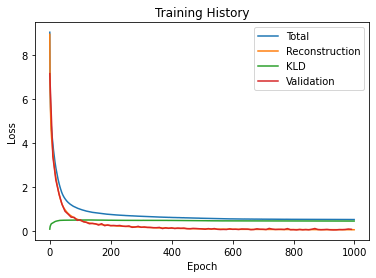

In [12]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

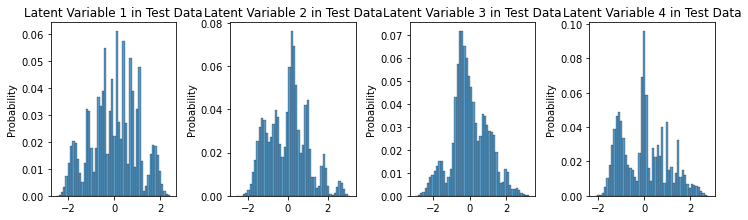

In [13]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [14]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 0.07152985036373138


In [15]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [16]:
# How many synthetic households to generate
POP_SIZE = 100000

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

start_time = time.time()

# Generate households; each hh has unique latent input
results = vae.decoder.predict([inputs, inputs[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

--- 1.9761309623718262 seconds ---


In [17]:
# Save raw output values to be conditional inputs for the person CVAE
synth_hh_ohe_df = pd.DataFrame()
synth_hh_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_ohe, 1, x)  # Most variables in PUMS are indexed from 1
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_ohe_df = pd.concat([synth_hh_ohe_df, result_df], axis=1)
    
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)

synth_hh_df.columns = VAR_NAMES

synth_hh_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
synth_hh_ohe_df.to_csv('data/synthetic_populations/wa_households_raw.csv', index=False)

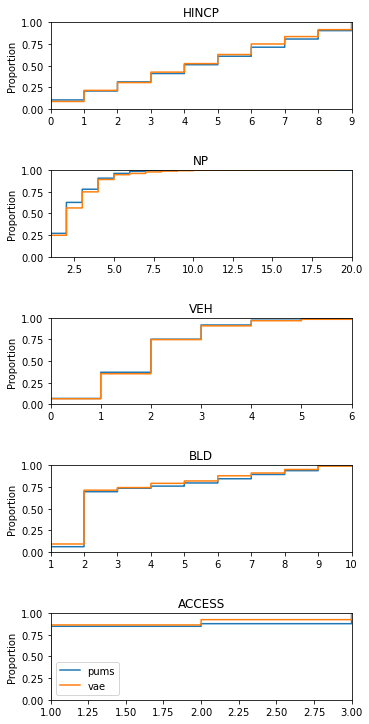

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_hh_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

In [19]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.15543949934299198, Total Bins: 47


IndexError: index 17 is out of bounds for axis 1 with size 17